# step 1 - crawling the data:

- the crawlimg was made by selenium
- the website name is - open food facts
- the program crawled from each product his name , nutri-score , and nutritions values.
- at the end of the crawling , the data is organized in a dataframe:
 each row represents a food item
 and each column represents a nutrition value except two columns - 
 one represents the name of the product,
 one represents the nutri-score of the product

In [8]:
import time
import random
import pandas as pd
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.chrome.webdriver import WebDriver as ChromeDriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from tabulate import tabulate


def driver(current_path):
    service = ChromeService(executable_path=current_path)
    driver = ChromeDriver(service=service)
    driver.maximize_window()
    return driver


def scrapper(driver, requested_pages_num):
    driver.get('https://world.openfoodfacts.org/38')

    # general data structure - predefined headers
    headers_list = ['Items', 'Nutri-Score', 'Energy', 'Fat', 'Saturated fat', 'Carbohydrates', 'Sugars', 'Fiber',
                    'Proteins', 'Salt']
    data_dict = {header: [] for header in headers_list}

    for page in range(requested_pages_num):

        # get all items elements
        parent_item_list = driver.find_element(By.ID, 'products_match_all')
        items_elements = parent_item_list.find_elements(By.TAG_NAME, 'li')

        # iterate over all items
        for item in items_elements:

            # get nutri score title
            item_content = item.find_element(By.TAG_NAME, 'a').find_element(By.TAG_NAME, 'div')
            nutri_score_title = item_content.find_elements(By.TAG_NAME, 'img')[1].get_attribute('title')

            # Verify if entered page for later use
            entered_page = False

            # enter page is item contains nutri score
            if not 'Missing data' in nutri_score_title:

                # click on item
                item.click()

                entered_page = True

                # get item name
                item_name = driver.find_element(By.XPATH, '//*[@property="food:name"]').text
                data_dict['Items'].append(item_name)

                # store nutri score to dict
                try:
                    nutri_score = driver.find_element(By.XPATH, '//*[contains(text(), "Nutri-Score")]').text.split(' ')[-1]
                    data_dict['Nutri-Score'].append(nutri_score)
                except:
                    data_dict['Nutri-Score'].append(None)

                # store nutritional facts to dict
                nutrients = headers_list[2:]

                table_parent = driver.find_element(By.TAG_NAME, 'table')

                # get all table rows from table parent without header row
                table_rows = table_parent.find_elements(By.TAG_NAME, 'tr')[1:]

                # copy current nutrients list and create nutri count
                nutri_count = 0
                missing_nutrients = nutrients.copy()

                for row in table_rows:
                    # get all rows cells
                    row_cells = row.find_elements(By.TAG_NAME, 'td')
                    # get first column text - nutrient header
                    nutrient = row_cells[0].text
                    # if current nutrient is part of predefined list, add it to relevant list
                    if nutrient in nutrients:
                        cell_data = row_cells[1].text

                        # get number value without nutrient indicator
                        if ' ' in cell_data:
                            cell_data = cell_data.split(' ')[0]

                        # add found value to correct list
                        data_dict[nutrient].append(cell_data)
                        # if nutrient was added to list add count of nutri_count
                        nutri_count += 1
                        # if nutrient was added, remove from missing_nutrients list
                        missing_nutrients.remove(nutrient)

                    # verify 8 nutrients copied to not iterate over all possible rows
                    if nutri_count == 8:
                        break

                # add none for any unused nutrients to have correct length of lists for df
                if missing_nutrients:
                    for nutrient in missing_nutrients:
                        data_dict[nutrient].append(None)

            # return to main page
            if entered_page:
                driver.back()


            # wait for main page to be displayed - max 20 sec
            wait = WebDriverWait(driver, 20)
            wait.until(EC.presence_of_element_located((By.XPATH, '//*[@class="filterProducts__buttons"]')))
            # time.sleep(random.randint(1, 5))

        # click on next page button
        driver.find_element(By.XPATH, '//*[contains(text(), "Next")]').click()

    # print df
    df = pd.DataFrame(data_dict)
    print(df)
    return df


current_path = r'C:\Users\noamd\Desktop\chromedriver.exe'
driver = driver(current_path)
food_items_df_before_cleaning = scrapper(driver, 30)

                                                  Items Nutri-Score Energy  \
0     Flan Nappé caramel - Carrefour kids - 400 g (4...           C    418   
1                                     Carrefour - 400 g           A  1,527   
2                         P'TIT DÉJ - Carrefour - 400 g           D  1,853   
3     Confiture abricot Les allégées en sucres - Dou...           C    689   
4     Farfalles au blé complet bio - Bio Village - 5...           A  1,454   
...                                                 ...         ...    ...   
2833               Lentilles vertes - Carrefour - 500 g           A  1,381   
2834  Compote aromatisé à la pomme et la fraise - Ve...           B    195   
2835              Pulco citronnade - Citron - Framboise           D     88   
2836          Atún claro en aceite de oliva - Hacendado           D  1,063   
2837              Flocons d’avoine bio - AUCHAN - 500 g           A  1,544   

       Fat Saturated fat Carbohydrates Sugars Fiber Proteins   

In [3]:
df1 = food_items_df_before_cleaning.copy()
df1

,Items,Nutri-Score,Energy,Fat,Saturated fat,Carbohydrates,Sugars,Fiber,Proteins,Salt
0,"Eau de source - Cristaline - 1,5 L",A,0,0,0,0,0,0,0,0.052
1,Nutella - Ferrero - 400 g,E,"2,252",30.9,10.6,57.5,56.3,0,6.3,0.107
2,Prince - Lu - 300 g,E,"1,962",17,5.6,69,32,0,6.3,0.49
3,Coca-cola - 330 mL,E,180,0,0,10.6,10.6,?,0,0
4,Nutella - Ferrero - 1 kg,E,"2,252",30.9,10.6,57.5,56.3,0,6.3,0.107
...,...,...,...,...,...,...,...,...,...,...
2910,Biscuits nappés de chocolat - Dukan - 160 g (4...,A,"1,665",18.1,6,45,1.9,16,14,0.12
2911,Harry Eiweiß-Brot - 500 g,A,"1,021",9.4,1.3,14,3.5,5.5,23,1
2912,Gewürzgurken - Kühne - 360g,C,126,0.2,0.1,4.9,4.7,1.3,0.9,1.6
2913,Beerenmüsli - Alnatura - 750g,A,"1,540",6.5,1.1,61,18,9.4,11,0.02


In [9]:
df2 = food_items_df_before_cleaning.copy()
df2

,Items,Nutri-Score,Energy,Fat,Saturated fat,Carbohydrates,Sugars,Fiber,Proteins,Salt
0,Flan Nappé caramel - Carrefour kids - 400 g (4...,C,418,0.9,0.6,20,18,0,2.6,0.1
1,Carrefour - 400 g,A,"1,527",6.8,0.8,58,4,7.6,15,0.001
2,P'TIT DÉJ - Carrefour - 400 g,D,"1,853",15,6.5,66,25,7,7.5,0.86
3,Confiture abricot Les allégées en sucres - Dou...,C,689,0.5,0.1,40,38,1.1,0.5,0.01
4,Farfalles au blé complet bio - Bio Village - 5...,A,"1,454",2,0.1,64,3.5,6.8,14,0
...,...,...,...,...,...,...,...,...,...,...
2833,Lentilles vertes - Carrefour - 500 g,A,"1,381",1.8,0.2,45,1.1,16,25,0.05
2834,Compote aromatisé à la pomme et la fraise - Ve...,B,195,0.2,0,10,10,1.6,0.3,0
2835,Pulco citronnade - Citron - Framboise,D,88,0,0,4.9,4.7,?,0,0
2836,Atún claro en aceite de oliva - Hacendado,D,"1,063",19.3,3.3,0,0,0,20,3


In [17]:
#merge dataframes:

def merge_dataframes(df1 , df2):
    merged_df = pd.concat([df1 , df2] , ignore_index = True)
    return merged_df

merged_df = merge_dataframes(df1 , df2)
merged_df

,Items,Nutri-Score,Energy,Fat,Saturated fat,Carbohydrates,Sugars,Fiber,Proteins,Salt
0,"Eau de source - Cristaline - 1,5 L",A,0,0,0,0,0,0,0,0.052
1,Nutella - Ferrero - 400 g,E,"2,252",30.9,10.6,57.5,56.3,0,6.3,0.107
2,Prince - Lu - 300 g,E,"1,962",17,5.6,69,32,0,6.3,0.49
3,Coca-cola - 330 mL,E,180,0,0,10.6,10.6,?,0,0
4,Nutella - Ferrero - 1 kg,E,"2,252",30.9,10.6,57.5,56.3,0,6.3,0.107
...,...,...,...,...,...,...,...,...,...,...
5748,Lentilles vertes - Carrefour - 500 g,A,"1,381",1.8,0.2,45,1.1,16,25,0.05
5749,Compote aromatisé à la pomme et la fraise - Ve...,B,195,0.2,0,10,10,1.6,0.3,0
5750,Pulco citronnade - Citron - Framboise,D,88,0,0,4.9,4.7,?,0,0
5751,Atún claro en aceite de oliva - Hacendado,D,"1,063",19.3,3.3,0,0,0,20,3


# step 2 - cleaning the data:

 ## the actions performed are:

- removing duplications
- handling missing data
- fitting the data type
- Removing unnecessary characters
- handling outliers


In [18]:
df_before_cleaning = merged_df.copy()

In [21]:
#cleaning the data:

def preprocess(df):
    data = df.copy()
    columns_to_convert = ['Energy','Fat','Saturated fat','Carbohydrates','Sugars','Fiber','Proteins','Salt']
    data[columns_to_convert] = data[columns_to_convert].replace(',', '', regex=True)
    data[columns_to_convert] = data[columns_to_convert].apply(pd.to_numeric, errors='coerce')
    data[columns_to_convert] = data[columns_to_convert].drop_duplicates(keep='first')
    data.dropna(inplace=True)
    data = data[data['Nutri-Score'] != 'not-applicable']

    return data

clean_df = preprocess(df_before_cleaning)

clean_df

,Items,Nutri-Score,Energy,Fat,Saturated fat,Carbohydrates,Sugars,Fiber,Proteins,Salt
0,"Eau de source - Cristaline - 1,5 L",A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052
1,Nutella - Ferrero - 400 g,E,2252.0,30.9,10.6,57.5,56.3,0.0,6.3,0.107
2,Prince - Lu - 300 g,E,1962.0,17.0,5.6,69.0,32.0,0.0,6.3,0.490
5,Coca Cola Zero - 330 ml,B,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020
6,Sésame - Gerblé - 230g,B,1961.0,18.0,2.0,64.0,17.0,4.6,10.0,0.380
...,...,...,...,...,...,...,...,...,...,...
5747,Pringles Smokey Bacon Flavour - 175g,D,2166.0,29.0,6.3,56.0,3.0,3.6,6.6,1.600
5748,Lentilles vertes - Carrefour - 500 g,A,1381.0,1.8,0.2,45.0,1.1,16.0,25.0,0.050
5749,Compote aromatisé à la pomme et la fraise - Ve...,B,195.0,0.2,0.0,10.0,10.0,1.6,0.3,0.000
5751,Atún claro en aceite de oliva - Hacendado,D,1063.0,19.3,3.3,0.0,0.0,0.0,20.0,3.000


# step 3 - EDA

## the actions performed are:

- converting the scores to numeric value 
- craeting a graph that shows the scores distribution
- creating frequency histogram for each nutrition value
- creating correlation matrix
- displaying mean of each value by level


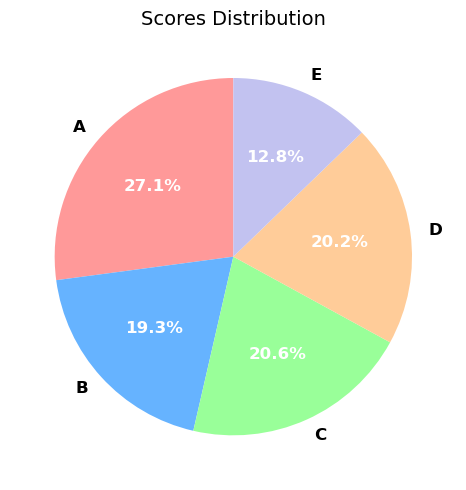

In [166]:
label_order = ['A','B','C','D','E']
label_count = clean_df['Nutri-Score'].value_counts()
sorted_label_count = label_count.reindex(label_order)

# Set the colors for the pie chart
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']

plt.figure(figsize=(5, 5))  # Set the figure size

# Plot the pie chart
_, _, autotexts = plt.pie(sorted_label_count, labels=sorted_label_count.index, autopct='%1.1f%%', startangle=90,
                          colors=colors, textprops={'fontsize': 12, 'fontweight': 'bold'})

# Set the text color of the percentage values inside the pie chart
for autotext in autotexts:
    autotext.set_color('white')

# Add title
plt.title('Scores Distribution', fontsize=14)

plt.tight_layout()  # Adjust spacing
plt.show()

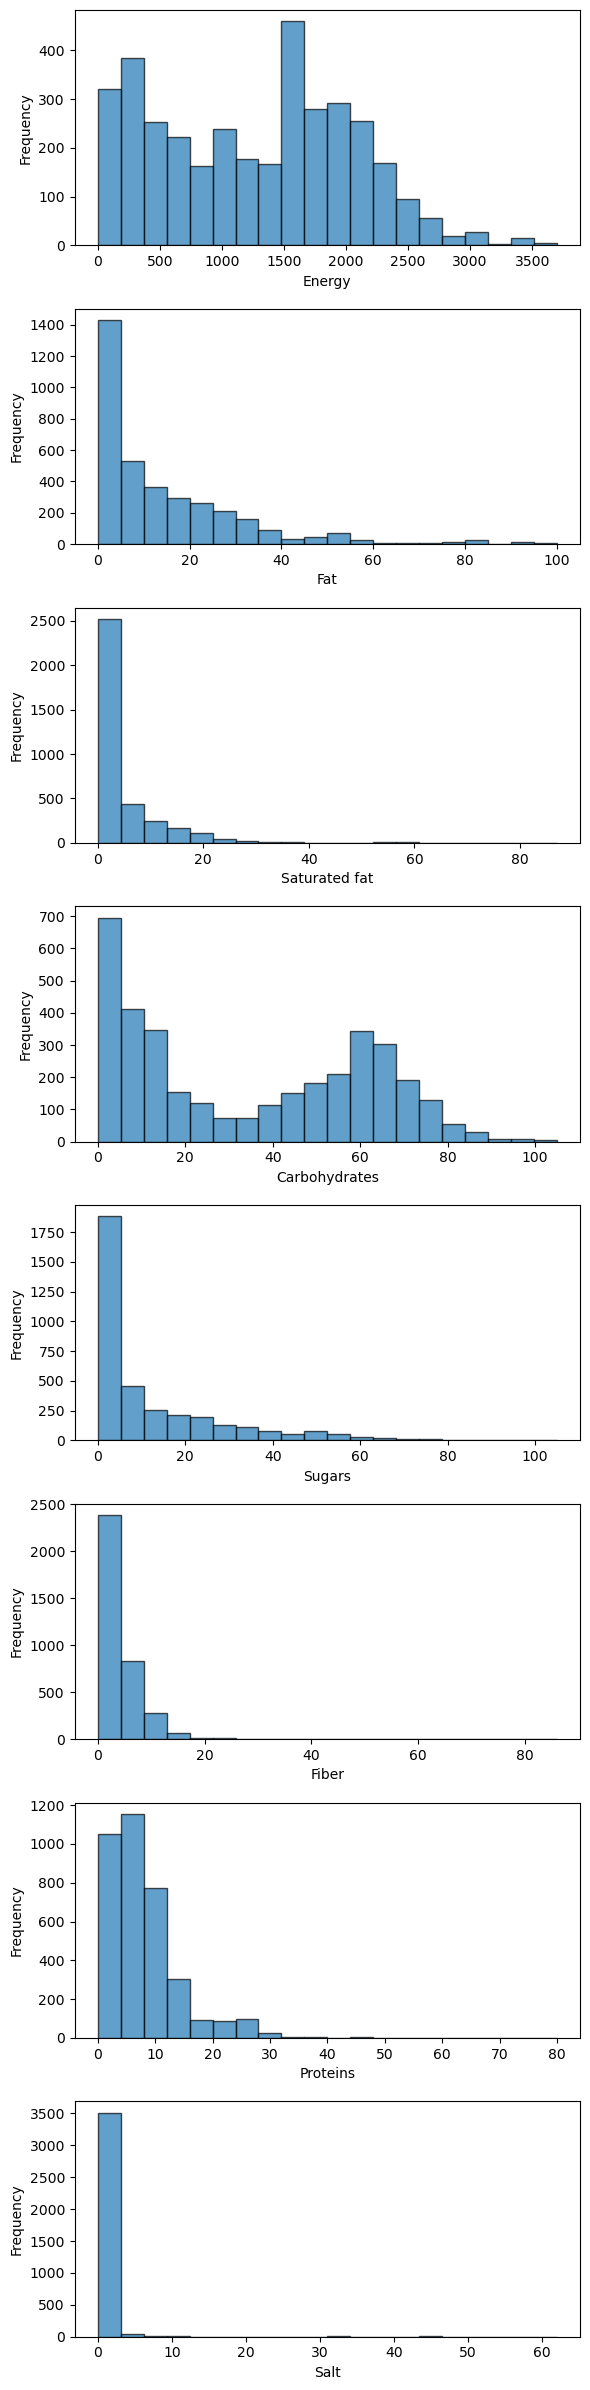

In [167]:
#creating frequency histogram for each nutrition value:
features = ['Energy','Fat','Saturated fat','Carbohydrates','Sugars','Fiber','Proteins','Salt']
fig, axs = plt.subplots(len(features), 1, figsize=(6, len(features) * 3))

for i, feature in enumerate(features):
    ax = axs[i]
    ax.hist(clean_df[feature], bins=20, edgecolor='black', alpha=0.7)
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

plt.tight_layout()

plt.show()

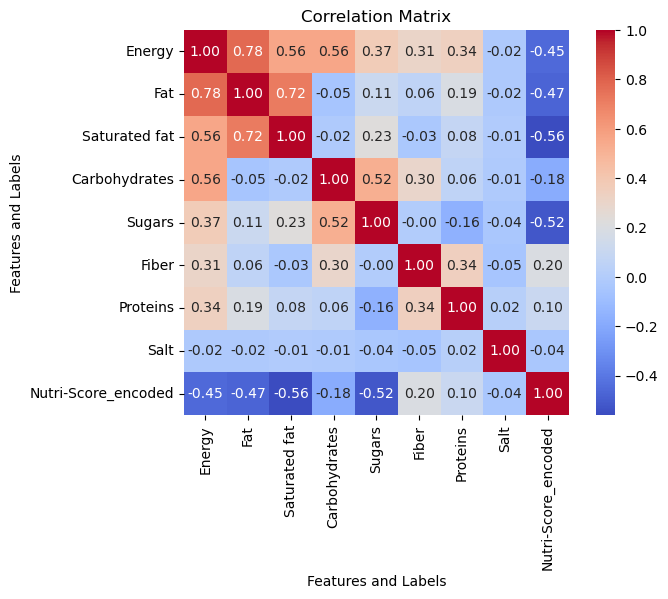

In [168]:
# creating correlation matrix:
import seaborn as sns

grade_encoding = {'A':5, 'B':4, 'C':3, 'D':2, 'E':1}
clean_df['Nutri-Score_encoded'] = clean_df['Nutri-Score'].map(grade_encoding)
names = clean_df['Items']
clean_df_nutrition_vals = clean_df.drop(columns=['Items','Nutri-Score'])

plt.figure(figsize=(7, 5))
sns.heatmap(clean_df_nutrition_vals.corr(), annot=True, cmap='coolwarm', fmt='.2f', square=True)

plt.xlabel('Features and Labels')
plt.ylabel('Features and Labels')
plt.title('Correlation Matrix')

plt.show()

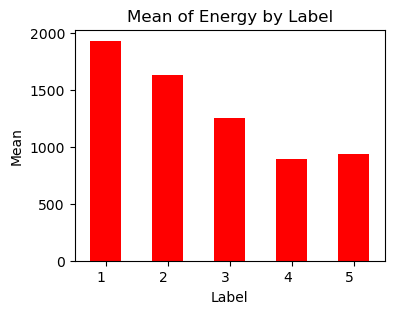

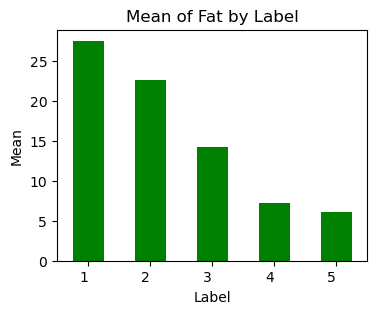

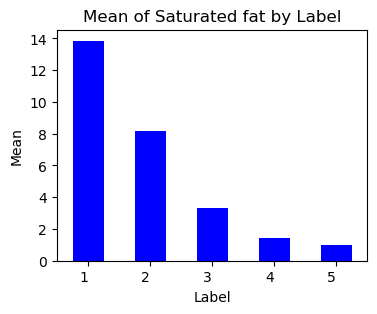

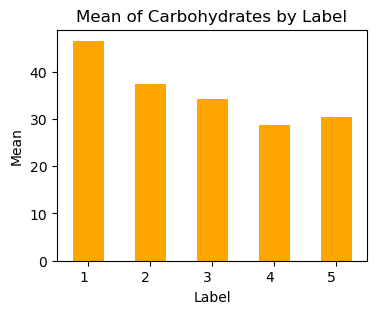

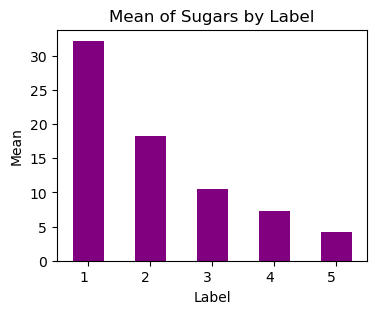

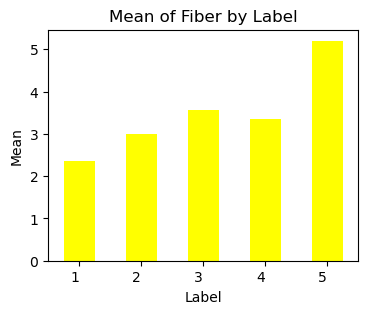

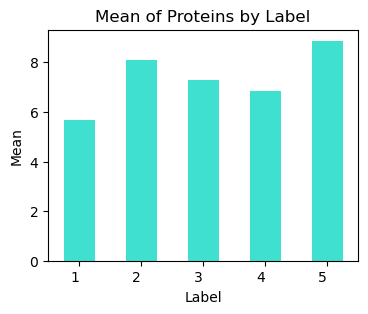

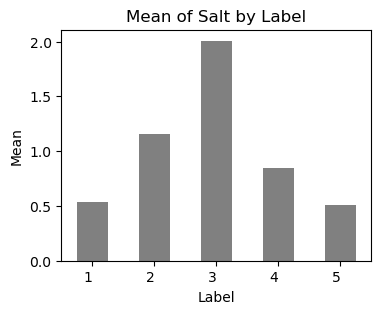

In [169]:
# creating histogrm for each nutrition value:
group_by_data = clean_df_nutrition_vals.groupby('Nutri-Score_encoded').mean()

colors = ['red', 'green', 'blue', 'orange', 'purple' , 'yellow' , 'turquoise' , 'grey']

for i , feature in enumerate(group_by_data.columns):
    plt.figure(figsize = (4,3))
    group_by_data[feature].plot(kind='bar' , color = colors[i])
    plt.xlabel('Label')
    plt.ylabel('Mean')
    plt.title(f'Mean of {feature} by Label')
    plt.xticks(range(len(group_by_data.index)), group_by_data.index, rotation=0, ha='right')
    
plt.show()

# step 4 - Machine Learning

  ## the actions performed are:

- splitting the data to train and test
- creating accuracy metric calculation function
- building machine learning models:
  KNN
  Naive Bayes
  Decision Tree
  Random Forest 
- presenting the results
   

In [170]:
# split the data to train and test:

from sklearn.model_selection import train_test_split

X = clean_df_nutrition_vals.drop(columns = ['Nutri-Score_encoded'])
y = clean_df_nutrition_vals['Nutri-Score_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (2880, 8) (2880,)
Testing set shape: (721, 8) (721,)


In [171]:
# accuracy metric calculation function:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score, recall_score, f1_score , accuracy_score
import numpy as np

def calculate_accuracy_metrics(y_test , y_predicted):
    #R2:
    r2 = r2_score(y_test, y_predicted)

    #MAE:
    mae = mean_absolute_error(y_test, y_predicted)

    #precision:
    precision = precision_score(y_test ,y_predicted ,average='macro')

    #recall:
    recall = recall_score(y_test ,y_predicted ,average='macro')

    #f1:
    f1 = f1_score(y_test ,y_predicted ,average='macro')
    
    #accuracy:
    accuracy = accuracy_score(y_test, y_predicted)

    return r2, mae, precision, recall, f1 , accuracy

#print accuracy metrics vals:

def print_accuracy_metrics_vals(r2_score_val, mae_score_val, precision_score_val, recall_score_val, f1_score_val , accuracy_score_val):

    print("R2 score:", r2_score_val)
    print("MAE:", mae_score_val)
    print("Precision:", precision_score_val)
    print("Recall:", recall_score_val)
    print("F1 score:", f1_score_val)
    print("accuracy:" , accuracy_score_val)
    

In [172]:
# displaying accuracy for each nutri-score:

def plot_accuracy_by_grade(y_test, y_predicted):
    
    unique_grades = np.unique(y_test)
    accuracy_by_grade = []

    for grade in unique_grades:
        mask = (y_test == grade)
        accuracy = np.mean(y_test[mask] == y_predicted[mask])
        accuracy_by_grade.append(accuracy)

    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_grades)))

    plt.bar(unique_grades, accuracy_by_grade, color=colors)
    plt.xlabel('Grade')
    plt.ylabel('Accuracy')
    plt.title('Accuracy by Grade')
    plt.ylim([0, 1])
    plt.xticks(unique_grades)

    plt.show()

R2 score: 0.37049427034166293
MAE: 0.6532593619972261
Precision: 0.5392938582251237
Recall: 0.5444668250649637
F1 score: 0.5375789668419108
accuracy: 0.536754507628294


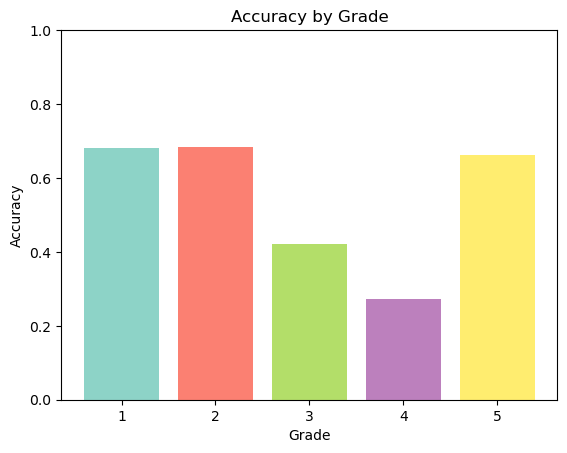

In [173]:
# KNN:
from sklearn.neighbors import KNeighborsClassifier

#model creating and fitting:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train , y_train)

y_predicted = knn_model.predict(X_test)

r2_score_val, mae_score_val, precision_score_val, recall_score_val, f1_score_val , accuracy_score_val = calculate_accuracy_metrics(y_test, y_predicted)

print_accuracy_metrics_vals(r2_score_val, mae_score_val, precision_score_val, recall_score_val, f1_score_val ,accuracy_score_val)

plot_accuracy_by_grade(y_test, y_predicted)


R2 score: 0.11029856874955024
MAE: 0.8765603328710125
Precision: 0.4445115771488696
Recall: 0.4331062713264401
F1 score: 0.35239351044950473
accuracy: 0.4160887656033287


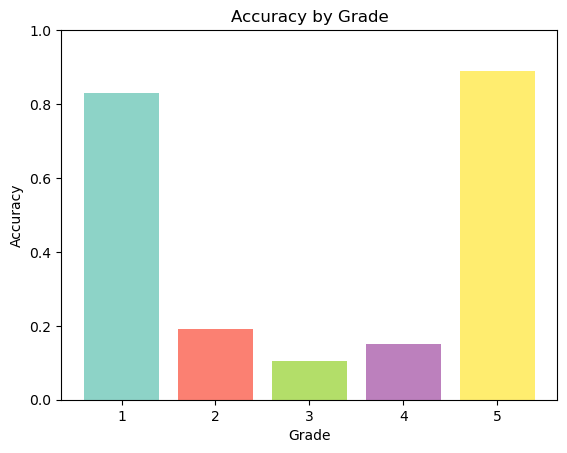

In [174]:
#NAIVE BAYES:
from sklearn.naive_bayes import GaussianNB

NB_model = GaussianNB()
NB_model.fit(X_train, y_train)

y_predicted = NB_model.predict(X_test)

r2_score_val, mae_score_val, precision_score_val, recall_score_val, f1_score_val , accuracy_score_val = calculate_accuracy_metrics(y_test, y_predicted)

print_accuracy_metrics_vals(r2_score_val, mae_score_val, precision_score_val, recall_score_val, f1_score_val ,accuracy_score_val)

plot_accuracy_by_grade(y_test, y_predicted)

R2 score: 0.7130979947254124
MAE: 0.37447988904299584
Precision: 0.7015875652646616
Recall: 0.6980333310707506
F1 score: 0.699554880406946
accuracy: 0.6893203883495146


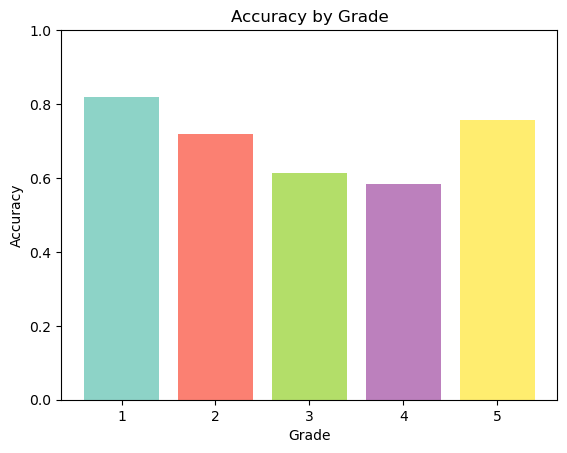

In [175]:
#DECISION TREE:
from sklearn.tree import DecisionTreeClassifier

desicion_tree_model = DecisionTreeClassifier()
desicion_tree_model.fit(X_train , y_train)

y_predicted = desicion_tree_model.predict(X_test)

r2_score_val, mae_score_val, precision_score_val, recall_score_val, f1_score_val , accuracy_score_val = calculate_accuracy_metrics(y_test, y_predicted)

print_accuracy_metrics_vals(r2_score_val, mae_score_val, precision_score_val, recall_score_val, f1_score_val ,accuracy_score_val)

plot_accuracy_by_grade(y_test, y_predicted)


R2 score: 0.8130558742226757
MAE: 0.24271844660194175
Precision: 0.804068781786253
Recall: 0.797085127837502
F1 score: 0.7992743296896199
accuracy: 0.7961165048543689


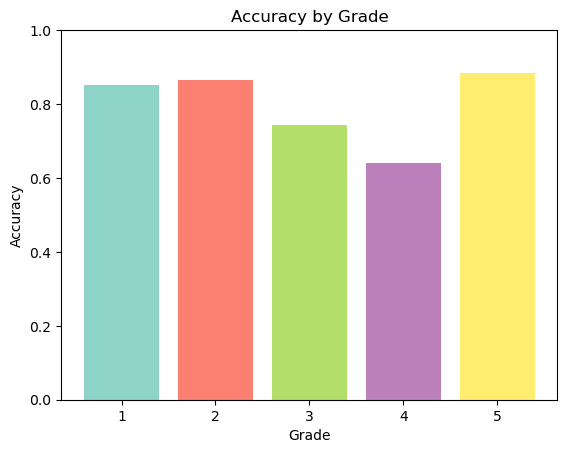

In [176]:
#RANDOM FOREST:
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier(n_estimators=100, random_state=42)
RF_model.fit(X_train, y_train)

y_predicted = RF_model.predict(X_test)

r2_score_val, mae_score_val, precision_score_val, recall_score_val, f1_score_val , accuracy_score_val = calculate_accuracy_metrics(y_test, y_predicted)

print_accuracy_metrics_vals(r2_score_val, mae_score_val, precision_score_val, recall_score_val, f1_score_val ,accuracy_score_val)

plot_accuracy_by_grade(y_test, y_predicted)

# 5 - summary and Conclusions:

- the nutri - score is predictable with 80% success by random forest model.
- the 'A' score , 'D' score , and 'E' score are the most predictable scores.
- sugar , fat , and saturated fat have a negative impact on the nutritional score.
- Protein and fiber values have a positive impact on the nutritional score, but not significantly.

